# Fourier Neural Operators (FNO)


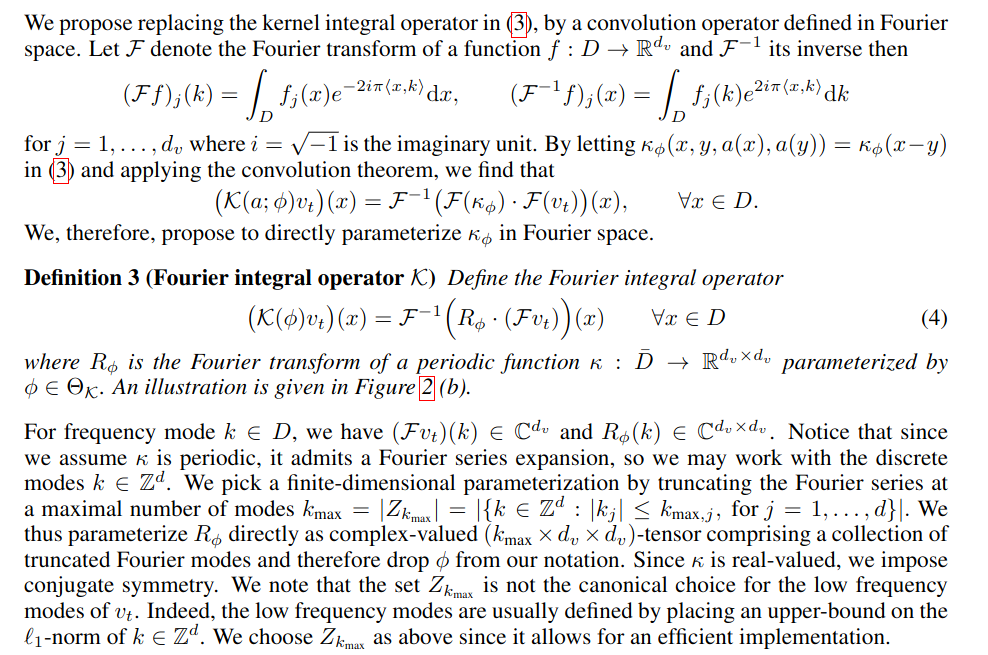

In FNO kernel is replaced by convolution done in fourier space 
\begin{equation}
v_{t+1}(x)= \sigma \left( W v_t(x) + \int_D \kappa_{\phi}\left(x,y,a(x),a(y)\right)v_t(y)dy\right); \forall x \in D \\
\left(\kappa_\phi v_t\right)(x) = F^{-1} \left(R_{\phi} \cdot (Fv_t)\right) (x)
\end{equation}

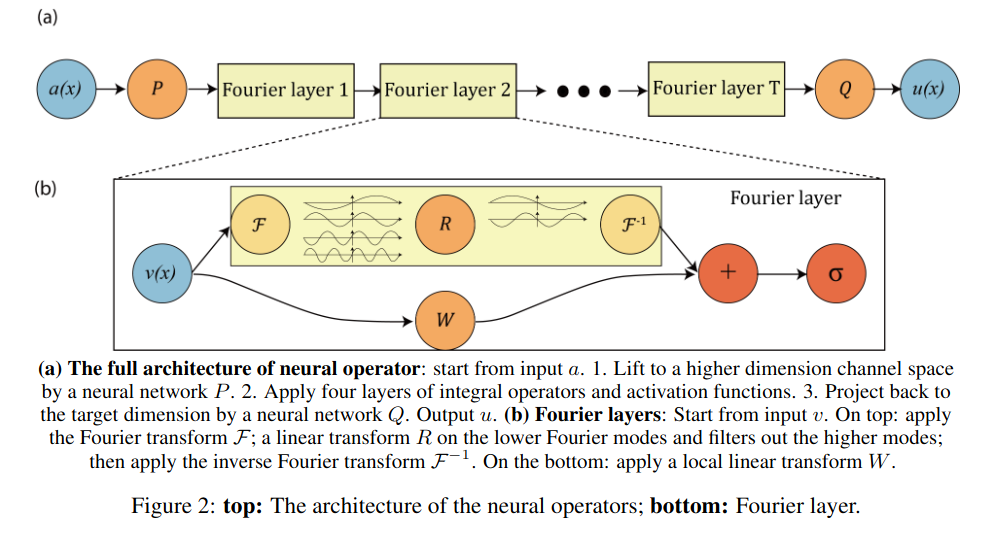


Paper: https://arxiv.org/pdf/2010.08895.pdf

Neural Operators are mappings between discretized function spaces, for example:

* Map from an initial condition to the solution function at a later point in time (or to the entire spatiotemporal solution funciton)
* Autoregressive timesteppers, map state $u^{[t]}_h$ to state $u_h^{[t+1]}$

Fourier Neural Operators do so by employing the FFT to perform efficient **spectral convolution** taking into account global features. In that sense they are a multiscale architecture (Classical convolutional architectures are only local and their receptive field depends on the depth of the network).

Neural Operators allow for the solution of a whole parametric family of PDEs!

FNOs allow for **zero-shot superresolution**.



## Steps 

Given the (real-valued) input discretized state $a$ (with potentially more than one channel) defined on an equidistant mesh; do the following steps:
1. Project $a$ using $P$ to give $v$
### N Fourier Block
---------------------------------------------------------
2. Transform $v$ into Fourier space (here using the real-valued Fourier transform): $\hat{v} = \text{rfft}(v)$ using only half of the fft points
3. Perform a batched matrix multiplication with a complex-valued weight vector $R$ for the first $K$ modes: $\hat{\tilde{v}}_{0:K} = R\hat{a}_{0:K}$
4. Set all the leftover modes to zero $\hat{\tilde{v}}_{K:} = 0 + 0i$
5. Transform back into real space $\tilde{v} = \text{irfft}(\hat{\tilde{v}})$
6. Convolute $v$ with W and add it to $\tilde{v}$ and pass it through activation function $\sigma$, $\tilde{v}=\sigma(W\cdot v + \tilde{v})$
-----------------------------------------------------------
8. Project $\tilde{v}$ back to original dimension using $Q$ 
9. Pass output of $Q$ through linear layer to give output $u$

The learnable parameters for each spectral convolution are the complex-valued weight matrix of shape `(channels_out, channels_in, modes)` (Since it is complex-valued it actually has `2 * channels_out * channels_in * modes` real parameters)

## Fourier Neural Operator Architecture

A classical FNO consists of a lifting layer, multiple "ResNet"-like blocks of spectral convolutions with a bypass, and a projection layer. Projection and Lifting layer are 1x1 Convolutions to only modify the channel dimensions. The blocks operate as $b = \text{activation}(\tilde{a} + \text{Conv}_{1\times1}(a))$.


## Darcy Flow Equation 2D

The steady-state of the 2-d Darcy Flow equation on the unit box which is the second order, linear, elliptic PDE

\begin{equation}
    -\nabla \cdot(a(x)\nabla u(x)) = f (x) ~ x \in (0, 1)^2  \\ 
    u(x) = 0 ~ x \in \partial(0, 1)^2 
\end{equation}

with a Dirichlet boundary where $a \in L^\infty ((0, 1)^2; R_{+})$ is the diffusion coefficient and $ f \in L^{2}((0, 1)^2; R)$ is the forcing function. This PDE has numerous applications including modeling the pressure of subsurface flow, the deformation of linearly elastic materials, and the electric potential in conductive materials. The operator mapping the diffusion coefficient to the solution,  defined by $G^{*} : a \rightarrow u$. Note that although the PDE is linear, the operator $G^*$ is not.

Forcing term is set to $f = 1$ and diffusion coefficient $a \sim \psi \neq \mu$, with $\mu$ being a Gaussian Process with zero mean and squared exponential kernel

\begin{equation}
    k(x,y) = \sigma^{2} \exp \left( \frac{|x-y|^2}{l^2} \right),~ \sigma^{2}=0.1
\end{equation}

We chose the length scale $l = 0.1$ for the in-distribution testing and $l = 0.05$ for the out-of-distribution testing. The mapping $\psi : R \rightarrow R$ takes the value 12 on the positive part of the real line and 3 on the negative part. 

## Wave Equation

Linear Hyperbolic PDE

\begin{equation}
    u_{tt} -c^2\nabla^{2} u = 0, \text{in} ~ D \times (0,T),~u_{0}(x,y) = f(x,y) \\
    f(x,y) = \frac{\pi}{K^2} \Sigma_{i,j=1}^{K} a_{ij}(i^2 + j^2)^{-r} \cdot \sin(\pi i x)sin(\pi jy), \forall (x,y) \in D
\end{equation}

with a constant propagation speed $c = 0.1$. The underlying operator $G^* : f \rightarrow u(., T )$ maps the initial condition f with r= 1 into the solution at the final time. The training and in-distribution test samples are generated by setting T = 5, K = 24 and $a_{ij}$ to be i.i.d. uniformly distributed from $[−1, 1] $.For out-of-distribution testing, the exponent r = 0.85 and K = 32.

Exact Solution at $t>0$

\begin{equation}
    u(x,y,t) = \frac{\pi}{K^2} \Sigma_{i,j=1}^{K} a_{ij}(i^2 + j^2)^{-r} \cdot \sin(\pi i x)sin(\pi jy) \cos\left(c\pi t\sqrt{i^2+j^2}\right), \forall (x,y) \in D
\end{equation}


## Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
import h5py
import math
import copy
import scipy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn.functional as Func
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

## Utils

In [13]:
def activation_selection(choice):
    if choice in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif choice in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif choice in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif choice in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif choice in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif choice in ['celu', 'CeLU']:
        return nn.CELU()
    elif choice in ['elu']:
        return nn.ELU()
    elif choice in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')
        
        
def default_param(network_properties):
    
    if "modes" not in network_properties:
        network_properties["modes"] = 16
    
    if "width" not in network_properties:
        network_properties["width"] = 32
    
    if "n_layers" not in network_properties:
        network_properties["n_layers"] = 4
        
    if "proj_scale" not in network_properties:
        network_properties["proj_scale"] = 32

    if "padding" not in network_properties:
        network_properties["padding"] = 0
    
    if "include_grid" not in network_properties:
        network_properties["include_grid"] = 1
    
    if "FourierF" not in network_properties:
        network_properties["FourierF"] = 0
    
    return network_properties


def default_train_params(training_properties):
    if "learning_rate" not in training_properties:
        training_properties["learning_rate"] = 0.001
        
    if "weight_deacy" not in training_properties:
        training_properties["weight_decay"] = 1e-6
        
    if "scheduler_step" not in training_properties:
        training_properties["scheduler_step"] = 0.98
        
    if "scheduler_gamma" not in training_properties:
        training_properties["scheduler_gamma"] = 10
        
    if "epochs" not in training_properties:
        training_properties["epochs"] = 1000
        
    if "batch_size" not in training_properties:
        training_properties["batch_size"] = 32
        
    if "exp" not in training_properties:
        training_properties["exp"] = 1
        
    if "training_samples" not in training_properties:
        training_properties["training_samples"] = 512
        
    return training_properties

In [4]:
units = {
    0: 'B',
    1: 'KiB',
    2: 'MiB',
    3: 'GiB',
    4: 'TiB'
}


def format_mem(x):
    """
    Takes integer 'x' in bytes and returns a number in [0, 1024) and
    the corresponding unit.

    """
    if abs(x) < 1024:
        return round(x, 2), 'B'

    scale = math.log2(abs(x)) // 10
    scaled_x = x / 1024 ** scale
    unit = units[scale]

    if int(scaled_x) == scaled_x:
        return int(scaled_x), unit

    # rounding leads to 2 or fewer decimal places, as required
    return round(scaled_x, 2), unit


def format_tensor_size(x):
    val, unit = format_mem(x)
    return f'{val}{unit}'


class CudaMemoryDebugger():
    """
    Helper to track changes in CUDA memory.

    """
    DEVICE = 'cuda'
    LAST_MEM = 0
    ENABLED = True


    def __init__(self, print_mem):
        self.print_mem = print_mem
        if not CudaMemoryDebugger.ENABLED:
            return

        cur_mem = torch.cuda.memory_allocated(CudaMemoryDebugger.DEVICE)
        cur_mem_fmt, cur_mem_unit = format_mem(cur_mem)
        print(f'cuda allocated (initial): {cur_mem_fmt:.2f}{cur_mem_unit}')
        CudaMemoryDebugger.LAST_MEM = cur_mem

    def print(self,id_str=None):
        if not CudaMemoryDebugger.ENABLED:
            return

        desc = 'cuda allocated'

        if id_str is not None:
            desc += f' ({id_str})'

        desc += ':'

        cur_mem = torch.cuda.memory_allocated(CudaMemoryDebugger.DEVICE)
        cur_mem_fmt, cur_mem_unit = format_mem(cur_mem)

        diff = cur_mem - CudaMemoryDebugger.LAST_MEM
        if self.print_mem:
            if diff == 0:
                print(f'{desc} {cur_mem_fmt:.2f}{cur_mem_unit} (no change)')

            else:
                diff_fmt, diff_unit = format_mem(diff)
                print(f'{desc} {cur_mem_fmt:.2f}{cur_mem_unit}'
                      f' ({diff_fmt:+}{diff_unit})')

        CudaMemoryDebugger.LAST_MEM = cur_mem


def print_tensor_mem(x, id_str=None):
    """
    Prints the memory required by tensor 'x'.

    """
    if not CudaMemoryDebugger.ENABLED:
        return

    desc = 'memory'

    if id_str is not None:
        desc += f' ({id_str})'

    desc += ':'

    val, unit = format_mem(x.element_size() * x.nelement())

    print(f'{desc} {val}{unit}')
    
    
class FourierFeatures(nn.Module):

    def __init__(self, scale, mapping_size, device):
        super().__init__()
        self.mapping_size = mapping_size  #fourier modes
        self.scale = scale
        self.B = scale * torch.randn((self.mapping_size, 2)).to(device)  # [mapping_size,2]

    def forward(self, x):
        # x is the set of coordinate and it is passed as a tensor (nx, ny, 2)
        if self.scale != 0:
            x_proj = torch.matmul((2. * np.pi * x), self.B.T) # [nx, ny, 2]*[2,mapping_size] ----> [nx, ny, mapping_size]
            inp = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], axis=-1) # [nx, ny, 2*mapping_size]
            return inp
        else:
            return x

## 1D Fourier Neural Operator

In [5]:
################################################################
# 1D Fourier Layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. Performs FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights_1d = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def complexmulti_1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0] # x.shape == [batch_size, in_channels, number of grid points]
        
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        # real FFT is redundant along that last dimension.
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.complexmulti_1d(x_ft[:, :, :self.modes1], self.weights_1d)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, fno_architecture, nfun =1, padding_frac=1/4, device="cpu"):
        super(FNO1d, self).__init__()

        """
        The network contains n_layers of the Fourier layer. 
        The following is done:
        1. Lift the input to the desire channel dimension by self.fc0 
        2. 4 layers of the integral operators u' = (W + K)(u).
           W defined by self.w; K defined by self.conv 
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: solution of the initial condition and location (a(x), x)
        input_shape: (batchsize, x=s=grid_size, channel=2)
        output: solution at a later timestep
        output_shape: (batchsize, x=s=grid_size, channel=1)
        """

        
        
        self.padding_frac = padding_frac
        self.modes1 = fno_architecture["modes"]
        self.width = fno_architecture["width"]
        self.n_layers = fno_architecture["n_layers"]
        self.proj_scale = fno_architecture["proj_scale"]
        self.device = device
        
        #lifting the input to fc0 (P layer)
        self.fc0 = nn.Linear(nfun + 1, self.width)  # input channel is 2: (u0(x), x)

        self.conv_list = nn.ModuleList(
            [nn.Conv1d(self.width, self.width, 1) for _ in range(self.n_layers)])
        self.spectral_list = nn.ModuleList(
            [SpectralConv1d(self.width, self.width, self.modes1) for _ in range(self.n_layers)])
        
        self.fc1 = nn.Linear(self.width, self.proj_scale)  # projecting from fc0 --> fc1 (Q layer)
        self.fc2 = nn.Linear(self.proj_scale, 1)  # output layer 

        self.to(device)

    def forward(self, x):
     
        x = self.fc0(x)   # Lifting: P layer
        x = x.permute(0, 2, 1)  # (batch_size, nfun+1, width) ---> (batch_size, width, nfun+1)
        x_padding = int(round(x.shape[-1] * self.padding_frac))
        x = Func.pad(x, [0, x_padding])  # pad the domain if input is non-periodic
        
        
        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):

            x1 = s(x)
            x2 = c(x)
            x = x1 + x2
            if k != self.n_layers - 1:
                x = Func.gelu(x)

        x = x[..., :-x_padding]
        x = x.permute(0, 2, 1) # (batch_size, width, nfun+1) ---> (batch_size, nfun+1, width)
        x = self.fc1(x)  # Projecting: Q layer
        x = Func.gelu(x)
        x = self.fc2(x)  # output layer
        return x.squeeze(-1)
    
 
    def print_size(self):
        nparams = 0
        nbytes = 0

        for param in self.parameters():
            nparams += param.numel()
            nbytes += param.data.element_size() * param.numel()

        print(f'Total number of model parameters: {nparams} (~{format_tensor_size(nbytes)})')

        return nparams

## 2D Fourier Neural Operator

In [6]:
################################################################
# 2D Fourier Layer
################################################################

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. Performs FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def complexmulti_2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]  # (batch, in_channel, x,y )
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        # real FFT is redundant along last dimension.
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.complexmulti_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.complexmulti_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    def __init__(self, fno_architecture, in_channels=1, out_channels=1, device="cpu"):
        super(FNO2d, self).__init__()

        """
        The network contains n_layers of the Fourier layer. 
        The following is done:
        1. Lift the input to the desire channel dimension by self.fc0 
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv 
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: solution of the initial condition and location (a(x,y), x, y)
        input_shape: (batchsize, x=s=grid_size, y=s=grid_size, channel=3)
        output: solution at a later timestep
        output_shape: (batchsize, x=s=grid_size, y=s=grid_size, channel=1)
        """
        self.modes1 = fno_architecture["modes"]
        self.modes2 = fno_architecture["modes"]
        self.width = fno_architecture["width"]
        self.n_layers = fno_architecture["n_layers"]
        self.proj_scale = 128
        self.padding = fno_architecture["padding"]
        self.include_grid = fno_architecture["include_grid"]
        self.input_dim = in_channels
        self.activation  = nn.LeakyReLU() 
        self.device = device
        
        if self.include_grid == 1:
            self.p = nn.Sequential(nn.Linear(self.input_dim+2, self.proj_scale),
                                   self.activation,
                                   nn.Linear(self.proj_scale, self.width))  # scaling: p layer
        else:
            self.p = nn.Sequential(nn.Linear(self.input_dim, self.proj_scale),
                                   self.activation,
                                   nn.Linear(self.proj_scale, self.width))   # scaling: p layer
        
        
        self.fc0 = nn.Linear(3, self.width)  # input channel is 3: (a(x, y), x, y)
        self.conv_list = nn.ModuleList([nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)])
        self.spectral_list = nn.ModuleList([SpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])

        
        self.q = nn.Sequential(nn.Linear(self.width, self.proj_scale),
                                self.activation,
                                nn.Linear(self.proj_scale, out_channels))  # projection: q layer 
        
        self.to(device)
                
    def get_grid(self, samples, res):
        size_x = size_y = res
        samples = samples
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([samples, size_y, 1, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, size_y, 1, 1).repeat([samples, 1, size_x, 1])
        grid = torch.cat((gridy, gridx), dim=-1)

        return grid

    def forward(self, x):
                
        if self.include_grid == 1:
            grid = self.get_grid(x.shape[0], x.shape[1]).to(self.device)
            x = torch.cat((grid, x), -1)
        
        x = self.p(x)
        x = x.permute(0, 3, 1, 2) # (batch_size, x, y, width) ---> (batch_size, width, x, y)
        
        x1_padding =  self.padding
        x2_padding =  self.padding
                
        if self.padding>0: 
            x = Func.pad(x, [0, x1_padding, 0, x2_padding])

        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):

            x1 = s(x)
            x2 = c(x)
            x = x1 + x2
            if k != self.n_layers - 1:
                x = self.activation(x)
        
        del x1
        del x2
        
        if self.padding > 0:
            x = x[..., :-x1_padding, :-x2_padding]            
        x = x.permute(0, 2, 3, 1)  # (batch_size, width, x, y) ---> (batch_size, x, y, width) 
        x = self.q(x)

        return x

    def print_size(self):
        nparams = 0
        nbytes = 0

        for param in self.parameters():
            nparams += param.numel()
            nbytes += param.data.element_size() * param.numel()

        print(f'Total number of model parameters: {nparams} (~{format_tensor_size(nbytes)})')

        return nparams

    

## Plot Function

In [14]:
def plot_data(x, y, index,example, z=0, out=False):
    if out:
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(1, 3, 1)
        ax.imshow(x.squeeze())
        ax.set_title('Input x')
        ax = fig.add_subplot(1, 3, 2)
        ax.imshow(y.squeeze())
        ax.set_title('Input y')
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(y.squeeze())
        ax.set_title('Model Prediction')
        fig.suptitle(f'Visualizing sample {index} of {example} problem', y=0.76)
        fig.tight_layout()
        fig.show()
            
    else: 
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(x.squeeze())
        ax.set_title('Input x')
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(y.squeeze())
        ax.set_title('Ouput y')
        fig.suptitle(f'Visualizing input sample {index} for {example} problem', y=0.75)
        fig.tight_layout()
        fig.show()

## Wave equation

Sample_0_t_1
<class 'h5py._hl.group.Group'>
input
output
torch.Size([64, 64]) torch.Size([64, 64])


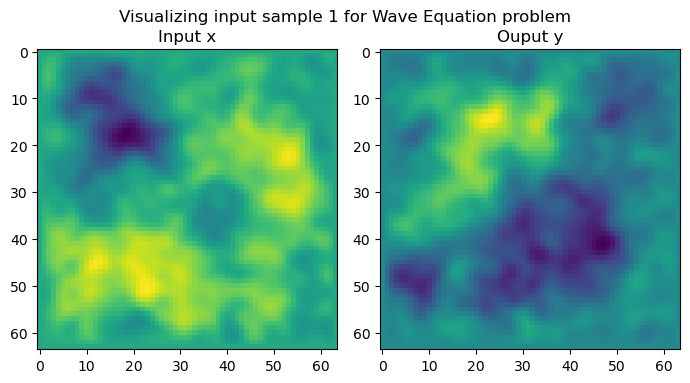

In [19]:
file = "/p/project/cexalab/john2/NeuralOperators/ConvolutionalNeuralOperator/data/WaveData_64x64_IN.h5"
with h5py.File(file, "r") as f:
    for key in f.keys():
        print(key) # Names of the root level object names in HDF5 file - can be groups or datasets.
        print(type(f[key])) # get the object type: usually group or dataset
        break
    
    
    index = 1
    start = 0 
    t = 5
    #Get the HDF5 group; key needs to be a group name from above
    group = f[key]

    #Checkout what keys are inside that group.
    for key in group.keys():
        print(key)

    x = torch.from_numpy(f['Sample_' + str(index + start)+"_t_"+str(t)]["input"][:]).type(torch.float32)
    y = torch.from_numpy(f['Sample_' + str(index + start)+"_t_"+str(t)]["output"][:]).type(torch.float32)
    print(x.shape,y.shape)

plot_data(x.reshape(1, x.shape[0], x.shape[1]), y.reshape(1, y.shape[0], y.shape[1]),index,example="Wave Equation", out=False)

### Wave Data Processing

In [21]:
# Wave data:
# From 0 to 512 : training samples (512)
# From 1024 to 1024 + 128 : validation samples (128)
# From 1024 + 128 to 1024 + 128 + 256 : test samples (256)
# Out-of-distribution testing samples: 0 to 256 (256)

class WaveEquationDataset(Dataset):
    def __init__(self, task="training", nf=0, training_samples = 1024, t = 5, s = 64, in_dist = True):
        
        # Data file:       
        if in_dist:
            self.file_data = "/p/project/cexalab/john2/NeuralOperators/ConvolutionalNeuralOperator/data/WaveData_64x64_IN.h5"
        else:
            self.file_data = "/p/project/cexalab/john2/NeuralOperators/ConvolutionalNeuralOperator/data/WaveData_64x64_OUT.h5"

        self.reader = h5py.File(self.file_data, 'r')
        
        # Load normaliation constants:
        self.min_data = self.reader['min_u0'][()]
        self.max_data = self.reader['max_u0'][()]
        self.min_model = self.reader['min_u'][()]
        self.max_model = self.reader['max_u'][()]
        
        # Time
        self.t = t
                        
        if task == "training":
            self.length = training_samples
            self.start = 0
        elif task == "validation":
            self.length = 128
            self.start = 1024
        elif task == "test":
            if in_dist:
                self.length = 256
                self.start = 1024 + 128
            else:
                self.length = 256
                self.start = 0
                
        # Grid size
        self.s = s
        
        #Fourier modes 
        self.N_Fourier_F = nf
        
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        inputs = torch.from_numpy(self.reader['Sample_' + str(index + self.start)+"_t_"+str(self.t)]["input"][:]).type(torch.float32).reshape(1, self.s, self.s)
        labels = torch.from_numpy(self.reader['Sample_' + str(index + self.start)+"_t_"+str(self.t)]["output"][:]).type(torch.float32).reshape(1, self.s, self.s)
        # normalising data 
        inputs = (inputs - self.min_data)/(self.max_data - self.min_data)
        labels = (labels - self.min_model)/(self.max_model - self.min_model)

        if self.N_Fourier_F > 0:
            grid = self.get_grid() # [s, s, 2]
            FF = FourierFeatures(1, self.N_Fourier_F, grid.device)
            # B shape torch.Size([N_Fourier_F, 2])
            # x_proj torch.Size([s, s, N_Fourier_F])
            ff_grid = FF(grid) # [s, s, 2*N_Fourier_F]
            ff_grid = ff_grid.permute(2, 0, 1) #[s, s, 2*N_Fourier_F] ---> [2*N_Fourier_F,s,s]
            inputs = torch.cat((inputs, ff_grid), 0) #([1,s,s],[2*N_Fourier,s,s]) ---> [2*N_Fourier_F+1,s,s]
            

        return inputs.permute(1, 2, 0), labels.permute(1, 2, 0) # [2*N_Fourier_F+1,s,s], [1,s,s] ---> [s,s,2*N_Fourier_F+1], [s,s,1]

    def get_grid(self):
        x = torch.linspace(0, 1, self.s) # [s]
        y = torch.linspace(0, 1, self.s) # [s]

        x_grid, y_grid = torch.meshgrid(x, y) # [s,s]

        x_grid = x_grid.unsqueeze(-1)  # [s,s,1]
        y_grid = y_grid.unsqueeze(-1)  # [s,s,1]
        grid = torch.cat((x_grid, y_grid), -1)  # [s,s,2]
        return grid


class WaveEquation:
    def __init__(self, network_properties, device, batch_size, training_samples = 1024, s = 64, in_dist = True):
        
        network_properties = default_param(network_properties)
        self.N_Fourier_F = network_properties["FourierF"]
    
        
        self.model = FNO2d(fno_architecture = network_properties, 
                            in_channels = 1 + 2 * self.N_Fourier_F, 
                            out_channels = 1, 
                            device=device) 
        
#         self.model = FNO1d(fno_architecture = network_properties,
#                            nfun=1,
#                            padding_frac=1/4,
#                            device=device)

        num_workers = 8
        
        self.train_loader = DataLoader(WaveEquationDataset("training", self.N_Fourier_F, training_samples, 5, s), batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.val_loader = DataLoader(WaveEquationDataset("validation", self.N_Fourier_F, training_samples, 5, s), batch_size=batch_size, shuffle=False, num_workers=num_workers)
        self.test_loader = DataLoader(WaveEquationDataset("test", self.N_Fourier_F, training_samples, 5, s, in_dist), batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Darcy Flow

grid
<class 'h5py._hl.dataset.Dataset'>
input
output
torch.Size([64, 64]) torch.Size([64, 64])


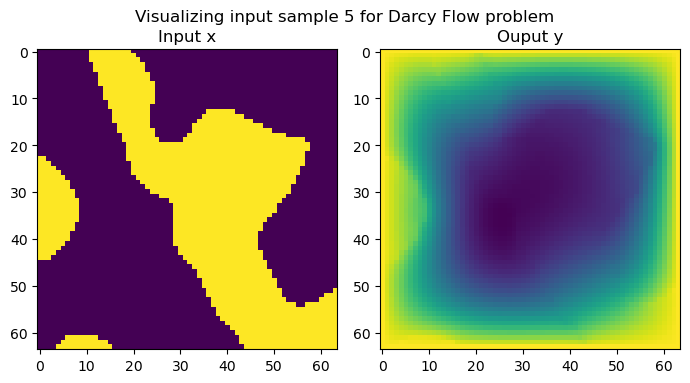

In [22]:
file = "/p/project/cexalab/john2/NeuralOperators/ConvolutionalNeuralOperator/data/Darcy_64x64_IN.h5"
with h5py.File(file, "r") as f:
    for key in f.keys():
        print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
        print(type(f[key])) # get the object type: usually group or dataset
        break
    
    
    index = 5
    start = 0 
    #Get the HDF5 group; key needs to be a group name from above
    group = f['sample_' + str(index + start)]

    #Checkout what keys are inside that group.
    for key in group.keys():
        print(key)

    x = torch.from_numpy(f['sample_' + str(index + start)]["input"][:]).type(torch.float32)
    y = torch.from_numpy(f['sample_' + str(index + start)]["output"][:]).type(torch.float32)
    print(x.shape,y.shape)
    
plot_data(x.reshape(1, x.shape[0], x.shape[1]), y.reshape(1, y.shape[0], y.shape[1]),index,example="Darcy Flow", out=False)

### Darcy Flow Data Processing

In [23]:
# Darcy Flow data
#   From 0 to 256 : training samples (256)
#   From 256 to 256 + 128 : validation samples (128)
#   From 256 + 128 to 256 + 128 + 128 : test samples (128)
#   Out-of-distribution testing samples: 0 to 128 (128)

class DarcyDataset(Dataset):
    def __init__(self, task="training", nf=0, training_samples=256, s=64, insample=True):

        if insample:
            self.file_data = "/p/project/cexalab/john2/NeuralOperators/ConvolutionalNeuralOperator/data/Darcy_64x64_IN.h5"
        else:
            self.file_data = "/p/project/cexalab/john2/NeuralOperators/ConvolutionalNeuralOperator/data/Darcy_64x64_IN.h5"
        
        
        self.reader = h5py.File(self.file_data, 'r')

        self.min_data = self.reader['min_inp'][()]
        self.max_data = self.reader['max_inp'][()]
        self.min_model = self.reader['min_out'][()]
        self.max_model = self.reader['max_out'][()]
                
        if task == "training":
            self.length = training_samples
            self.start = 0
        elif task == "validation":
            self.length = 128
            self.start = training_samples
        elif task == "testing":
            if insample:
                self.length = 128
                self.start = training_samples + 128
            else:
                self.length = 128
                self.start = 0

        self.N_Fourier_F = nf
        self.s = s

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        inputs = torch.from_numpy(self.reader['sample_' + str(index + self.start)]["input"][:]).type(torch.float32).reshape(1, self.s, self.s)
        labels = torch.from_numpy(self.reader['sample_' + str(index + self.start)]["output"][:]).type(torch.float32).reshape(1, self.s, self.s)
        # normalisation
        inputs = (inputs - self.min_data) / (self.max_data - self.min_data)
        labels = (labels - self.min_model) / (self.max_model - self.min_model)

        if self.N_Fourier_F > 0:
            grid = self.get_grid()  # [s, s, 2*N_Fourier_F]
            FF = FourierFeatures(1, self.N_Fourier_F, grid.device)
             # B shape torch.Size([N_Fourier_F, 2])
            # x_proj torch.Size([s, s, N_Fourier_F])
            ff_grid = FF(grid) # [s, s, 2*N_Fourier_F]
            ff_grid = ff_grid.permute(2, 0, 1)  #[s, s, 2*N_Fourier_F] ---> [2*N_Fourier_F,s,s]
            inputs = torch.cat((inputs, ff_grid), 0) #([1,s,s],[2*N_Fourier,s,s]) ---> [2*N_Fourier_F+1,s,s]

        return inputs.permute(1, 2, 0), labels.permute(1, 2, 0) # [2*N_Fourier_F+1,s,s], [1,s,s] ---> [s,s,2*N_Fourier_F+1], [s,s,1]

    def get_grid(self):
        x = torch.linspace(0, 1, s) # [s]
        y = torch.linspace(0, 1, s) # [s]

        x_grid, y_grid = torch.meshgrid(x, y) # [s,s]

        x_grid = x_grid.unsqueeze(-1) # [s,s,1]
        y_grid = y_grid.unsqueeze(-1)  # [s,s,1]
        grid = torch.cat((x_grid, y_grid), -1)  # [s,s,2]
  
        return grid

class Darcy:
    def __init__(self, network_properties, device, batch_size, training_samples = 512,  s = 64, in_dist = True):
        
        network_properties = default_param(network_properties)
        self.N_Fourier_F = network_properties["FourierF"]
        
        self.model = FNO2d(fno_architecture = network_properties, 
                            in_channels = 1 + 2 * self.N_Fourier_F, 
                            out_channels = 1, 
                            device=device) 
        # self.model = FNO1d(fno_architecture = network_properties,
                           # nfun=1,
                           # padding_frac=1/4,
                           # device=device)
                           

        num_workers = 8

        self.train_loader = DataLoader(DarcyDataset("training", self.N_Fourier_F, training_samples), batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.val_loader = DataLoader(DarcyDataset("validation", self.N_Fourier_F, training_samples), batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.test_loader = DataLoader(DarcyDataset("testing", self.N_Fourier_F, training_samples, in_dist), batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Defining Hyperparameters

In [25]:
# Chose example
example = "darcy"  #darcy, wave
folder = "/p/project/cexalab/john2/NeuralOperators/FNO/TrainModels/"+"FNO_"+example+"_tmp1"
if not os.path.isdir(folder):
    os.mkdir(folder)
    print("Generated new folder")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter(log_dir=folder)

In [26]:
network_properties = {}
training_properties = {}
fno_architecture = default_param(network_properties)
training_properties = default_train_params(training_properties)


learning_rate = training_properties["learning_rate"]
# training_properties["epochs"] = 1000 
epochs = training_properties["epochs"]
batch_size = training_properties["batch_size"]
weight_decay = training_properties["weight_decay"]
scheduler_step = training_properties["scheduler_step"]
scheduler_gamma = training_properties["scheduler_gamma"]
training_samples = training_properties["training_samples"]
p = training_properties["exp"]


if example == "wave":
    problem = WaveEquation(fno_architecture, device, batch_size,training_samples)
elif example == "darcy":
    problem = Darcy(fno_architecture, device, batch_size,training_samples)
else:
    raise ValueError("the variable which_example has to be one between darcy")
    
df = pd.DataFrame.from_dict([training_properties]).T
df.to_csv(folder + '/training_properties.txt', header=False, index=True, mode='w')
df = pd.DataFrame.from_dict([fno_architecture]).T
df.to_csv(folder + '/net_architecture.txt', header=False, index=True, mode='w')

print("Training paramaters:", training_properties)
print("FNO model:", fno_architecture)


Training paramaters: {'learning_rate': 0.001, 'weight_decay': 1e-06, 'scheduler_step': 0.98, 'scheduler_gamma': 10, 'epochs': 1000, 'batch_size': 32, 'exp': 1, 'training_samples': 512}
FNO model: {'modes': 16, 'width': 32, 'n_layers': 4, 'proj_scale': 32, 'padding': 0, 'include_grid': 1, 'FourierF': 0}


## Model Training

In [39]:
model = problem.model
n_params = model.print_size()
train_loader = problem.train_loader
test_loader = problem.val_loader
epochs = training_properties["epochs"] 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

freq_print = 1
if p == 1:
    loss = torch.nn.SmoothL1Loss()
elif p == 2:
    loss = torch.nn.MSELoss()
    
best_model_testing_error = 300
threshold = int(0.25 * epochs)
counter = 0
train_loss_history = []
train_relative_l2_history = []
val_loss_history = []

for epoch in range(epochs):
    with tqdm(unit="batch", disable=False) as tepoch:
        model.train()
        tepoch.set_description(f"Epoch {epoch}")
        train_mse = 0.0
        # running_relative_train_mse = 0.0
        for step, (input_batch, output_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            input_batch = input_batch.to(device)
            output_batch = output_batch.to(device)
            output_pred_batch = model(input_batch)
            loss_f = loss(output_pred_batch, output_batch) / loss(torch.zeros_like(output_batch).to(device), output_batch)
            loss_f.backward()
            optimizer.step()
            train_mse = train_mse * step / (step + 1) + loss_f.item() / (step + 1)
            tepoch.set_postfix({'Batch': step + 1, 'Train loss (in progress)': train_mse})
            train_loss_history.append(train_mse)
            
        writer.add_scalar("train_loss/train_loss", train_mse, epoch)

        with torch.no_grad():
            model.eval()
            test_relative_l2 = 0.0
            train_relative_l2 = 0.0

            for step, (input_batch, output_batch) in enumerate(test_loader):
                input_batch = input_batch.to(device)
                output_batch = output_batch.to(device)
                output_pred_batch = model(input_batch)
                
                loss_f = torch.mean(abs(output_pred_batch - output_batch)) / torch.mean(abs(output_batch)) * 100
                test_relative_l2 += loss_f.item()
            test_relative_l2 /= len(test_loader)
            
            for step, (input_batch, output_batch) in enumerate(train_loader):
                    input_batch = input_batch.to(device)
                    output_batch = output_batch.to(device)
                    output_pred_batch = model(input_batch)
                    
                    loss_f = torch.mean(abs(output_pred_batch - output_batch)) / torch.mean(abs(output_batch)) * 100
                    train_relative_l2 += loss_f.item()
            train_relative_l2 /= len(train_loader)
            
            writer.add_scalar("train_loss/train_loss_rel", train_relative_l2, epoch)
            train_relative_l2_history.append(train_relative_l2)
            writer.add_scalar("val_loss/val_loss", test_relative_l2, epoch)
            val_loss_history.append(test_relative_l2)

            if test_relative_l2 < best_model_testing_error:
                best_model_testing_error = test_relative_l2
                best_model = copy.deepcopy(model)
                torch.save(best_model, folder + "/model.pkl")
                writer.add_scalar("val_loss/Best Relative Testing Error", best_model_testing_error, epoch)
                counter = 0
            else:
                counter +=1

        tepoch.set_postfix({'Train loss': train_mse, "Relative Train": train_relative_l2, "Relative Val loss": test_relative_l2})
        tepoch.close()
        
        #print(epoch, "val_loss/val_loss", test_relative_l2, epoch)
        
        with open(folder + '/errors.txt', 'w') as file:
            file.write("Training Error: " + str(train_mse) + "\n")
            file.write("Best Testing Error: " + str(best_model_testing_error) + "\n")
            file.write("Current Epoch: " + str(epoch) + "\n")
            file.write("Params: " + str(n_params) + "\n")
        scheduler.step()
    
    if counter>threshold:
        print("Early Stopping")
        break

Total number of model parameters: 2110497 (~16.05MiB)


Epoch 0: : 0batch [00:11, ?batch/s, Train loss=0.379, Relative Train=29.9, Relative Val loss=27.8]
Epoch 1: : 0batch [00:10, ?batch/s, Train loss=0.0511, Relative Train=15.3, Relative Val loss=16.5]
Epoch 2: : 0batch [00:11, ?batch/s, Train loss=0.0299, Relative Train=12.9, Relative Val loss=13.2]
Epoch 3: : 0batch [00:12, ?batch/s, Train loss=0.0267, Relative Train=11.9, Relative Val loss=12.9]
Epoch 4: : 0batch [00:11, ?batch/s, Train loss=0.0187, Relative Train=10.4, Relative Val loss=11]
Epoch 5: : 0batch [00:11, ?batch/s, Train loss=0.0156, Relative Train=9.77, Relative Val loss=10.8]
Epoch 6: : 0batch [00:12, ?batch/s, Train loss=0.0139, Relative Train=9.15, Relative Val loss=9.87]
Epoch 7: : 0batch [00:11, ?batch/s, Train loss=0.0121, Relative Train=8.59, Relative Val loss=8.9]
Epoch 8: : 0batch [00:11, ?batch/s, Train loss=0.00979, Relative Train=6.95, Relative Val loss=7.31]
Epoch 9: : 0batch [00:12, ?batch/s, Train loss=0.00609, Relative Train=5.63, Relative Val loss=5.85]


## Loss plotting

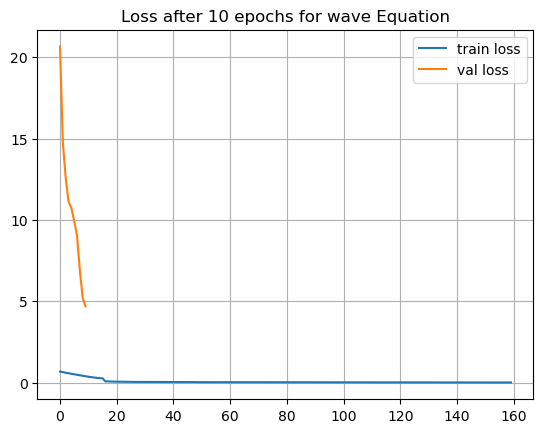

In [254]:
%matplotlib inline
plt.title(f"Loss after {training_properties['epochs']} epochs for {example} Equation")
plt.plot(train_loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
# plt.yscale("log")
plt.grid()
plt.show()
     

## Result Visualization

FFT input =  torch.Size([64, 64, 33])
torch.Size([64, 64])


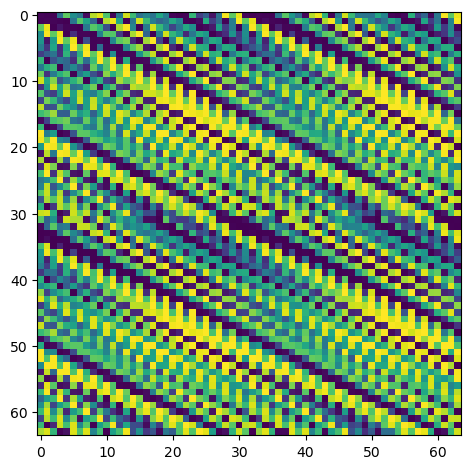

In [76]:
sample = 7
wave_data = WaveEquationDataset("training", 16, 256, 5, s=64)
input, label = wave_data.__getitem__(sample)
print("FFT input = ",input.shape)
modes = input.shape[2]
input = input.reshape(modes, input.shape[0], input.shape[1])
print(input[1].shape)
fig, ax = plt.subplots()
for i in range(modes):
    ax.imshow(input[i])
fig.tight_layout()
fig.show()


input, output, prediction =  torch.Size([16, 64, 64, 1]) torch.Size([16, 64, 64, 1]) torch.Size([16, 64, 64, 1])


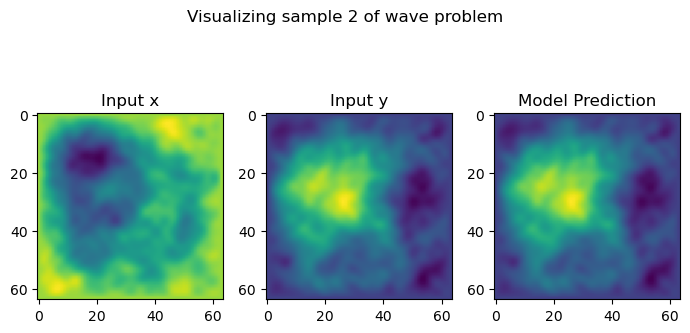

In [69]:
index = 2
for step, (input_batch, output_batch) in enumerate(problem.train_loader):
            output_pred_batch = model(input_batch)
            print("input, output, prediction = ",input_batch.shape, output_batch.shape, output_pred_batch.shape)
            for i in range(index,index+1):
                x = input_batch[i]
                y = output_batch[i]
                z = output_pred_batch[i].detach().numpy()
                # print(x.shape,y.shape, z.shape)
                plot_data(x, y,index,z,out=True)
            
            break
